In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import warnings
import geopandas as gpd
import pandas as pd
import regionmask
from cmip_preprocessing_funcs import *
import os
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from joblib import dump
print("DONE")



DONE


In [2]:
def create_df_full(ds_final):
    # Convert the xarray dataset to a pandas DataFrame
    df_full = ds_final.to_dataframe()

    df_full['lat'] = df_full.index.get_level_values('lat')
    df_full['lon'] = df_full.index.get_level_values('lon')
    # Extract year and month from the time dimension
    df_full['year'] = df_full.index.get_level_values('time').year
    df_full['month'] = df_full.index.get_level_values('time').month

    # Create cyclical features for months
    angle = (df_full['month'] - 1) * (2. * np.pi / 12)
    df_full['sin_month'] = np.sin(angle)
    df_full['cos_month'] = np.cos(angle)

    # Drop the month column
    del df_full['month']
    
    df_full['count_nobs'] = df_full['count_nobs'].fillna(0)

    return df_full

In [3]:
def assign_error(df_measured, instrumental_error_std=3):
    # Generate spatiotemporal error with varying standard deviation
    spatiotemporal_error = np.random.normal(loc=0, scale=df_measured['spco2_cmems_std']) #

    # Generate instrumental error
    instrumental_error = np.random.normal(loc=0, scale=instrumental_error_std, size=len(df_measured))
    
    # Calculate the total error
    spco2_cmems_random = df_measured['spco2_cmems'] + instrumental_error + spatiotemporal_error
    return spco2_cmems_random


In [4]:
def calculate_statistics(errors_df, df_testing, df_full, n_sims):

    # Calculate the mean error
    spatial_df = errors_df.groupby(level=['lon', 'lat']).mean().mean(axis=1)

    # Add MAE as a new column in spatial_df
    spatial_df = spatial_df.to_frame(name='mean_error')  # Convert Series to DataFrame if not already
    spatial_df['mae'] = errors_df.abs().groupby(level=['lon', 'lat']).mean().mean(axis=1)
    spatial_df['rmse'] = np.sqrt(errors_df.pow(2).groupby(level=['lon', 'lat']).mean().mean(axis=1))
    spatial_df['med_abs_error'] = errors_df.abs().groupby(level=['lon', 'lat']).median().mean(axis=1)
    
    spatial_df.reset_index(inplace=True)
    
    
    resolution = 0.25
    # Define the range of latitude and longitude
    lat_range = np.arange(spatial_df['lat'].min(), spatial_df['lat'].max() + resolution, resolution)  # Adjust the step as needed
    lon_range = np.arange(spatial_df['lon'].min(), spatial_df['lon'].max() + resolution, resolution)  # Adjust the step as needed
    
    # Create a blank grid (DataFrame)
    blank_grid = pd.DataFrame(index=pd.MultiIndex.from_product([lat_range, lon_range], names=['lat', 'lon'])).reset_index()
    
    # Merge the blank grid with spatial_df
    merged_df = blank_grid.merge(spatial_df.reset_index(), on=['lat', 'lon'], how='left')

    # Set the index back to ['lat', 'lon'] and convert to xarray
    merged_df = merged_df.set_index(['lat', 'lon'])
    spatial_xr = merged_df.to_xarray()

    # Calculate the average weight for each 'time' group
    average_weights = df_testing.groupby('time')['area'].transform('mean')

    # Normalize weights so that the average weight in each group is 1
    normalized_weights = df_testing['area'] / average_weights
    
    weighted_errors_df = errors_df.mul(normalized_weights, axis=0)
    
    # Calculate weighted mean error
    weighted_mean_error = weighted_errors_df.groupby('time').mean()

    # Calculate weighted MAE
    weighted_mae = weighted_errors_df.abs().groupby('time').mean()

    # Calculate weighted RMSE
    weighted_rmse = np.sqrt((weighted_errors_df.pow(2)).groupby('time').mean())
    
    # Calculate weighted med_abs_error
    weighted_med_abs_error = weighted_errors_df.abs().groupby('time').median()
    
    # Combining the statistics
    temporal_df = pd.DataFrame({
        'mean_error': weighted_mean_error.mean(axis=1),
        'mae': weighted_mae.mean(axis=1),
        'rmse': weighted_rmse.mean(axis=1),
        'med_abs_error': weighted_med_abs_error.mean(axis=1)
    })
    
    
    # Initialize a list to store the results
    simulation_results = []

    # Loop through each simulation
    for sim in range(n_sims):  # Assuming n_sims is the number of simulations
        sim_column = f'spco2_error_sim{sim}'

        # Ensure the column exists in the DataFrame
        if sim_column in weighted_errors_df.columns:
            # Calculate the statistics
            average_error = weighted_errors_df[sim_column].mean()
            mae = weighted_errors_df[sim_column].abs().mean()
            rmse = np.sqrt((weighted_errors_df[sim_column].pow(2)).mean())
            med_abs_error = weighted_errors_df[sim_column].abs().median()
            
            # Append the results to the list
            simulation_results.append({
                'simulation': sim,
                'average_error': average_error,
                'mae': mae,
                'rmse': rmse,
                'med_abs_error': med_abs_error
            })

    # Create a DataFrame from the list
    simulations_df = pd.DataFrame(simulation_results)

    return spatial_xr, temporal_df, simulations_df


In [5]:
def OSSE(lme, n_clust, n_sims=10):
    print(f"=============== {lme} SIMULATIONS BEGINNING ==============")
    ncpath = f'../Data/Fall 2023/{lme}_Clusters.nc'
    ds_final = xr.open_dataset(ncpath)

    socat_path = '../Data/Fall 2023/SOCAT.nc'
    ds_socat = xr.open_dataset(socat_path)

    ds_final['count_nobs'] = ds_socat['count_nobs']
    ds_final['spco2_socat_std'] = ds_socat['fco2_std']
    ds_final['area'] = ds_socat['area']



    df_full = create_df_full(ds_final)
    df_testing = df_full.dropna(subset = ['lme']).copy()

    rfr_predictors = ['lon', 'lat', 'year', 'sin_month', 'cos_month', 
                      'SSS', 'SSH', 'SST', 'IceC', 'CHL', 'WindSpeed', 'Bathy', 'MLD', 'mslp', 'pCO2_atm', 'dist']

    if lme in ['Chukchi and North Bering Seas', 'Beaufort Sea']:
        rfr_predictors.remove('SSH')
        rfr_predictors.remove('CHL')

    df_measured = df_testing.query("count_nobs > 0").copy()

    errors_df = pd.DataFrame()

    
    print("MODELLING BEGINNING")
    for simulation_id in range(n_sims):
        df_measured['spco2_cmems_random'] = assign_error(df_measured)

        for i in range(n_clust):
            df_model = df_measured.query(f"c{i} >= 0.1")
            X_all = df_model[rfr_predictors]
            Y_all = df_model['spco2_cmems_random'] 

            rfr_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=7, 
                                           oob_score=False, random_state=69420)
            rfr_model.fit(X_all, Y_all)
            df_testing[f'c{i}_pred'] = rfr_model.predict(df_testing[rfr_predictors])
        
        # Create a list comprehension that multiplies corresponding 'cX' and 'cX_pred' columns
        products = [df_testing[f'c{i}'] * df_testing[f'c{i}_pred'] for i in range(n_clust)]
        df_testing['spco2_pred'] = sum(products)
        
        # NaN out all cells where IceC > 0.1
        df_testing['spco2_pred'] = np.where(df_testing['IceC'] > 0.1, np.nan, df_testing['spco2_pred'])

        errors_df[f'spco2_error_sim{simulation_id}'] = df_testing['spco2_cmems'] - df_testing['spco2_pred']
        print(f'========= SIMULATION {simulation_id} COMPLETE! ============')
  


    # Align and divide the errors by the standard deviations to get z-scores
    aligned_errors_df, aligned_std_df = errors_df.align(df_full['spco2_cmems_std'], axis=0, join='inner')
    z_errors_df = aligned_errors_df.div(aligned_std_df, axis=0)

    # Calculate statistics for original errors
    spatial_xr, temporal_df, simulations_df = calculate_statistics(errors_df, df_testing, df_full, n_sims)

    # Calculate statistics for z-scores errors
    spatial_z_xr, temporal_z_df, simulations_z_df = calculate_statistics(z_errors_df, df_testing, df_full, n_sims)

    
    # For xarray datasets, rename variables and then merge
    spatial_z_xr = spatial_z_xr.rename({var: var + '_z' for var in spatial_z_xr})
    spatial_xr_combined = xr.merge([spatial_xr, spatial_z_xr])

    # For pandas DataFrames, add '_z' suffix to columns and then merge
    temporal_z_df.columns = [col + '_z' for col in temporal_z_df.columns]
    temporal_df_combined = pd.concat([temporal_df, temporal_z_df], axis=1)
    
    # Similarly, for the simulations DataFrame
    simulations_z_df.columns = [col + '_z' for col in simulations_z_df.columns]
    simulations_df_combined = pd.concat([simulations_df, simulations_z_df], axis=1)


    print(f"=============== {lme} SIMULATIONS COMPLETE ==============")
    return spatial_xr_combined, temporal_df_combined, simulations_df_combined

In [6]:
shp = gpd.read_file('../Data/New EIWG LMEs/eiwg_boundaries_20230512_ZachS_ChangeLongto0_360.shp')
lmes = list(shp['RegionName'])[:11]

# Corresponding n_clusts values
n_clusts = [2, 5, 3, 5, 2, 2, 3, 4, 2, 4, 5]

lmes_n_clusts_dict = dict(zip(lmes, n_clusts))

for lme, n_clust in lmes_n_clusts_dict.items():
    spatial_xr, temporal_df, simulations_df = OSSE(lme, n_clust, n_sims = 10)
    spatial_xr.to_netcdf(f'../Data/Fall 2023/{lme} Spatial Error.nc')
    temporal_df.to_csv(f'../Data/Fall 2023/{lme} Temporal Error.csv')
    simulations_df.to_csv(f'../Data/Fall 2023/{lme} Simulations Error.csv')

=============== U.S. Caribbean SIMULATIONS BEGINNING ==============
MODELLING BEGINNING
========= SIMULATION 0 COMPLETE! ============
========= SIMULATION 1 COMPLETE! ============
========= SIMULATION 2 COMPLETE! ============
========= SIMULATION 3 COMPLETE! ============
========= SIMULATION 4 COMPLETE! ============
========= SIMULATION 5 COMPLETE! ============
========= SIMULATION 6 COMPLETE! ============
========= SIMULATION 7 COMPLETE! ============
========= SIMULATION 8 COMPLETE! ============
========= SIMULATION 9 COMPLETE! ============
=============== U.S. Caribbean SIMULATIONS COMPLETE ==============
=============== Pacific Islands SIMULATIONS BEGINNING ==============
MODELLING BEGINNING
========= SIMULATION 0 COMPLETE! ============
========= SIMULATION 1 COMPLETE! ============
========= SIMULATION 2 COMPLETE! ============
========= SIMULATION 3 COMPLETE! ============
========= SIMULATION 4 COMPLETE! ============
========= SIMULATION 5 COMPLETE! ============
========= SIMULATION

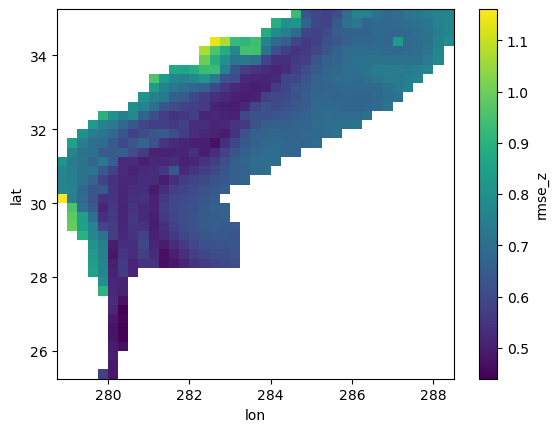

In [7]:
spatial_xr['rmse_z'].plot()

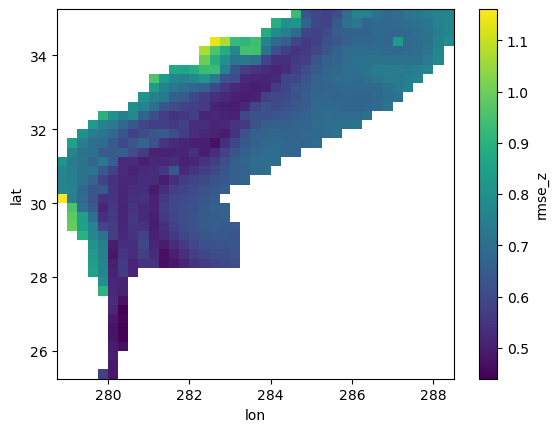

In [8]:
spatial_xr['rmse_z'].plot()

NameError: name 'ds' is not defined

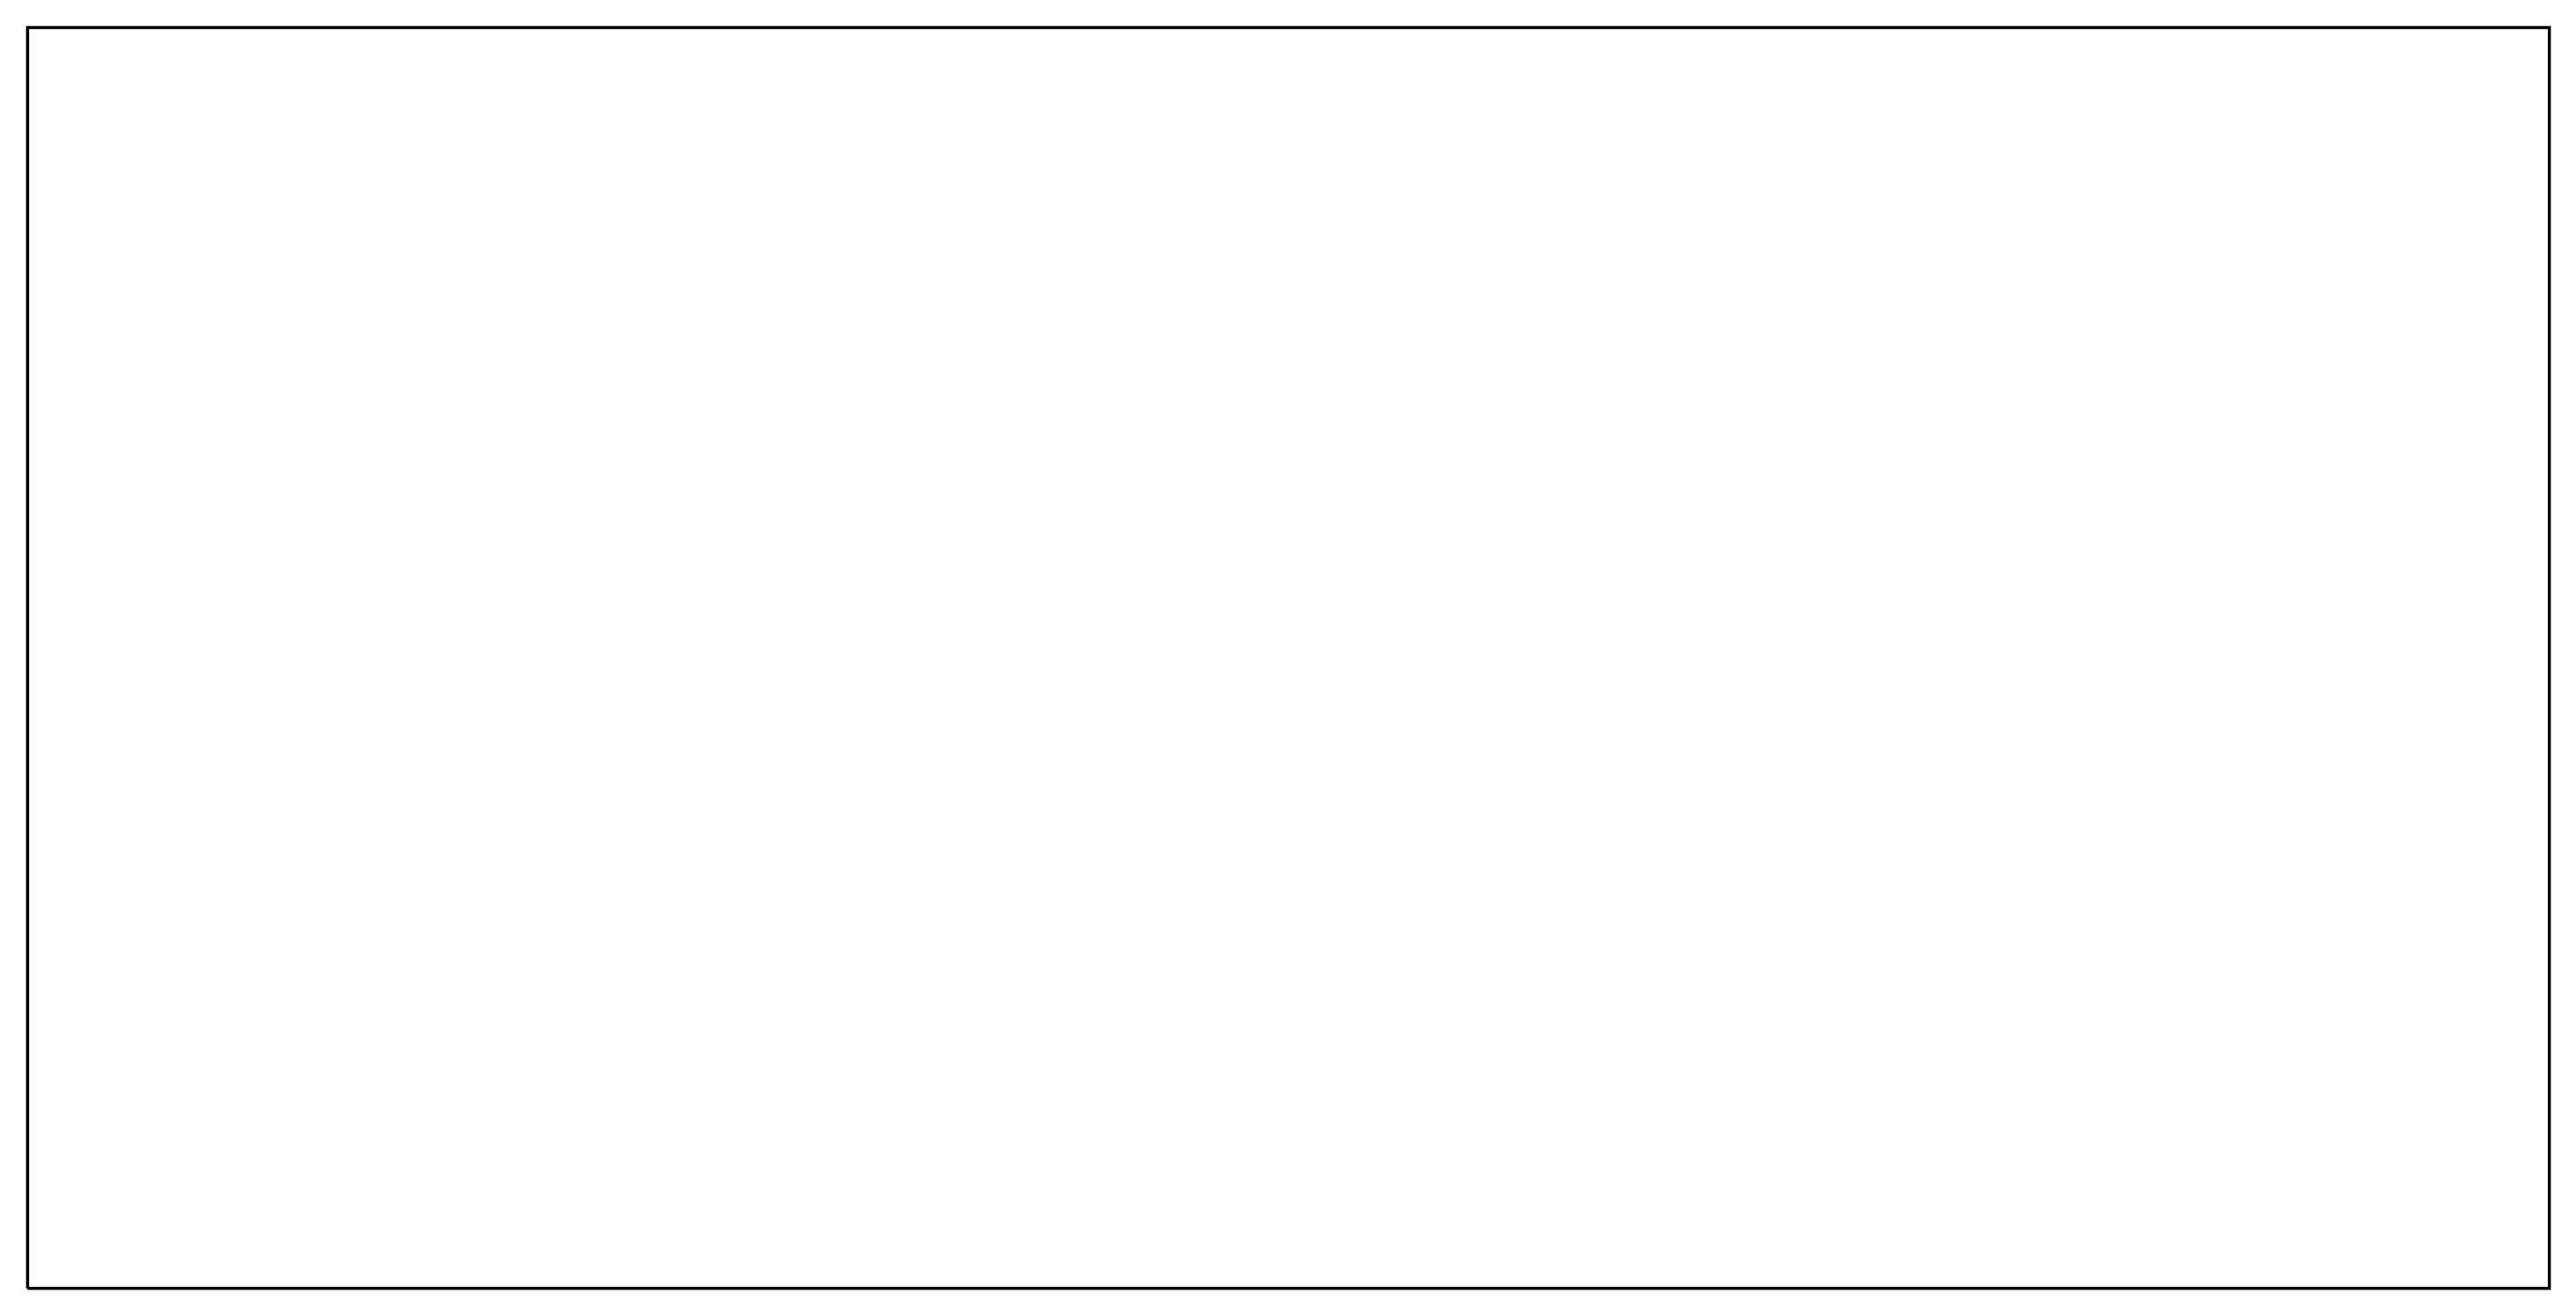